# Training

In [1]:
# Parameters cells
WITNESS_NAME = None
SIMULATION_PATH = "./simulated_data"
MLFLOW_URL = None
AIRFLOW_DAG_RUN_ID = None
AWS_ACCESS_KEY_ID="minio123"
AWS_SECRET_ACCESS_KEY="minio123"
MLFLOW_S3_ENDPOINT_URL="http://localhost:9990"

In [2]:
from os import environ

environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY

In [3]:
import numpy as np
import tensorflow as tf;
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from entanglement_witnesses import witnesses
import mlflow
import os

2024-06-02 14:07:50.853149: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-02 14:07:50.880931: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-02 14:07:51.325492: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
if MLFLOW_URL is not None:
    mlflow.set_tracking_uri(MLFLOW_URL)
    environ["MLFLOW_S3_ENDPOINT_URL"] = MLFLOW_S3_ENDPOINT_URL

In [5]:
def get_model(name, data_file_path):

    data = np.load(data_file_path)
    simulated_states = data["states"]
    simulated_labels = data["labels"]

    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(simulated_states.shape[1],)),  # Adjust input shape based on your data
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    X_train, X_val, y_train, y_val = train_test_split(simulated_states, simulated_labels, test_size=0.2, random_state=42)
    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))
    loss, accuracy = model.evaluate(X_val, y_val)

    metrics = {
        "loss": loss,
        "accuracy": accuracy
    }

    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model {} Accuracy'.format(name))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model {} Loss'.format(name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return model, metrics

In [6]:
def get_simulation_data_path(name):
    filename = "simulation-{}.npz".format(name)
    if AIRFLOW_DAG_RUN_ID is None:
        data_file_path = os.path.join("./simulated_data", filename)
    else:
        client = mlflow.tracking.MlflowClient()

        experiments = client.search_experiments(
            filter_string = "name = 'ML Quantum Entanglement'"
        )
        experiment_id = experiments[0].experiment_id

        runs = client.search_runs(
            experiment_ids=[experiment_id], 
            filter_string=f"tags.airflow_dag_run_id = '{AIRFLOW_DAG_RUN_ID}'"
        )
        run_id = runs[0].info.run_id
        local_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="simulated_data")
        data_file_path = os.path.join(local_path, filename)
    return data_file_path

In [7]:
def log_mlflow_model(model, witness_name, metrics):
    if MLFLOW_URL is None:
        return
    
    mlflow.set_experiment('ML Quantum Entanglement')
    
    # Start an MLflow run and log the model
    with mlflow.start_run() as run:
        # Log the model
        mlflow.tensorflow.log_model(model, "model")

        # Log parameters
        mlflow.log_param("witness", witness_name)

        # Evaluate the model and log metrics
        for metric_name, metric_value in metrics.items():
            mlflow.log_metric(metric_name, metric_value)

        # Register the model
        model_name = "QuantumStateClassifier-" + witness_name
        model_uri = f"runs:/{run.info.run_id}/model"
        mlflow.register_model(model_uri, model_name)
        print(f"Model saved in run {run.info.run_id}")

/home/faical/anaconda3/envs/quantum-entanglement/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-02 14:07:52.392766: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-02 14:07:52.418960: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentati

Epoch 1/20


I0000 00:00:1717330073.065677  158538 service.cc:145] XLA service 0x7a7ae0004cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717330073.065702  158538 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2024-06-02 14:07:53.078291: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-02 14:07:53.152789: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 81/150 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.6706 - loss: 0.6190

I0000 00:00:1717330073.759604  158538 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7113 - loss: 0.5552 - val_accuracy: 0.9875 - val_loss: 0.0779
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.9893 - loss: 0.0556 - val_accuracy: 0.9942 - val_loss: 0.0170
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.9940 - loss: 0.0256 - val_accuracy: 0.9975 - val_loss: 0.0096
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.9950 - loss: 0.0195 - val_accuracy: 0.9983 - val_loss: 0.0076
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.9968 - loss: 0.0133 - val_accuracy: 0.9992 - val_loss: 0.0074
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.9972 - loss: 0.0125 - val_accuracy: 0.9992 - val_loss: 0.0059
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.9956 - loss: 0.0146 - val_accuracy: 0.9992 - val_loss: 0.0048
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9981 - loss: 0.0073 - val_accuracy: 0

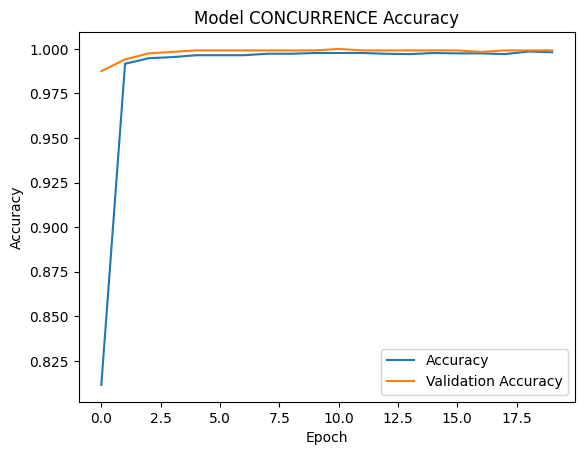

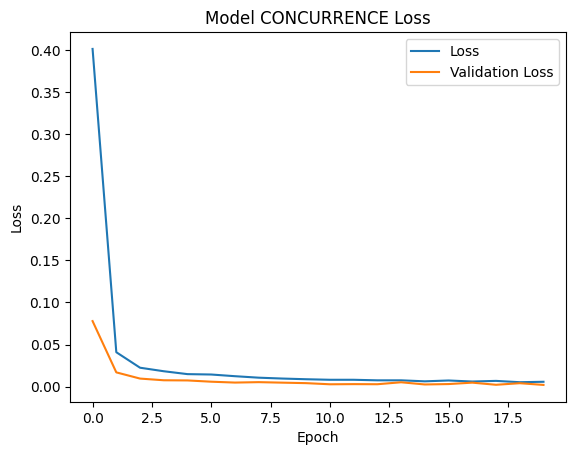

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7163 - loss: 0.5491 - val_accuracy: 0.9783 - val_loss: 0.0854
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.9943 - loss: 0.0413 - val_accuracy: 0.9900 - val_loss: 0.0254
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.9963 - loss: 0.0139 - val_accuracy: 0.9942 - val_loss: 0.0155
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.9980 - loss: 0.0075 - val_accuracy: 0.9967 - val_loss: 0.0118
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.9993 - loss: 0.0041 - val_accuracy: 0.9975 - val_loss: 0.0096
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.9989 - loss: 0.0032 - val_accuracy: 0.9975 - val_loss: 0.0078
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.9999 - loss: 0.0020 - val_accuracy: 0.9975 - val_loss: 0.0074
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.9997 - loss: 0.0017 - va

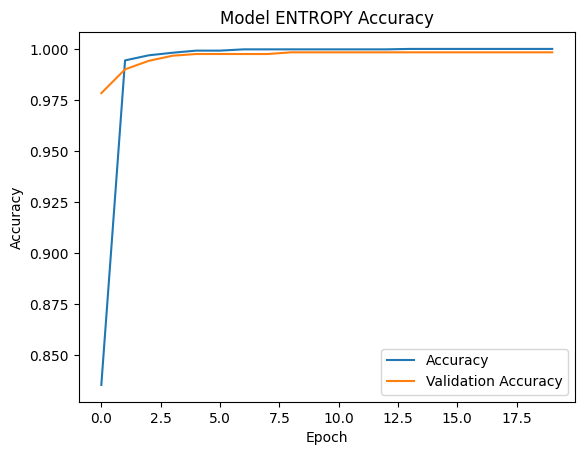

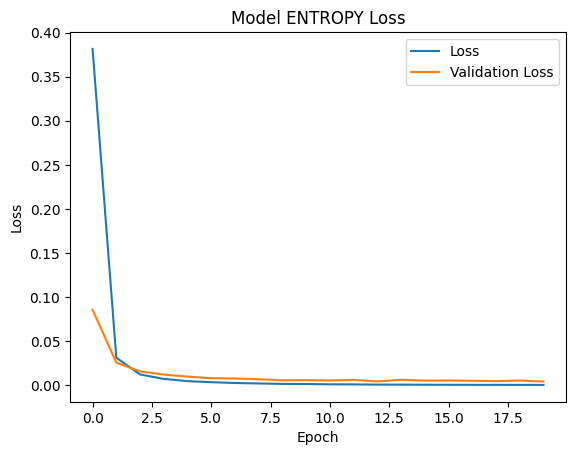

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7157 - loss: 0.5394 - val_accuracy: 0.9917 - val_loss: 0.0623
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.9881 - loss: 0.0514 - val_accuracy: 0.9975 - val_loss: 0.0144
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.9971 - loss: 0.0154 - val_accuracy: 0.9983 - val_loss: 0.0073
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9978 - loss: 0.0090 - val_accuracy: 0.9983 - val_loss: 0.0054
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.9985 - loss: 0.0056 - val_accuracy: 0.9992 - val_loss: 0.0040
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.9992 - loss: 0.0037 - val_accuracy: 0.9992 - val_loss: 0.0036
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.9992 - val_loss: 0.0035
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.9999 - loss: 0.0018 - val_ac

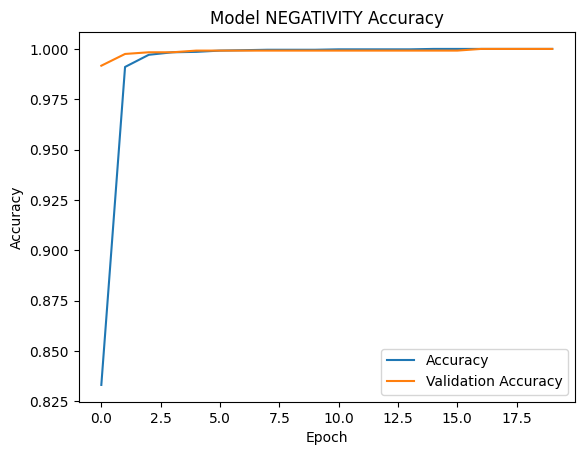

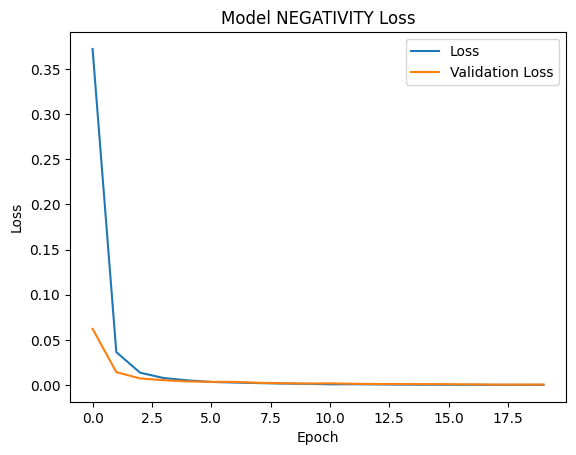

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7439 - loss: 0.5547 - val_accuracy: 0.9267 - val_loss: 0.2925
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.9335 - loss: 0.2122 - val_accuracy: 0.9825 - val_loss: 0.1084
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.9806 - loss: 0.0933 - val_accuracy: 0.9817 - val_loss: 0.0753
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - accuracy: 0.9832 - loss: 0.0664 - val_accuracy: 0.9842 - val_loss: 0.0584
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.9846 - loss: 0.0498 - val_accuracy: 0.9908 - val_loss: 0.0476
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.9885 - loss: 0.0458 - val_accuracy: 0.9908 - val_loss: 0.0420
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.9873 - loss: 0.0432 - val_accuracy: 0.9933 - val_loss: 0.0353
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9899 - loss: 0.0367 - val_

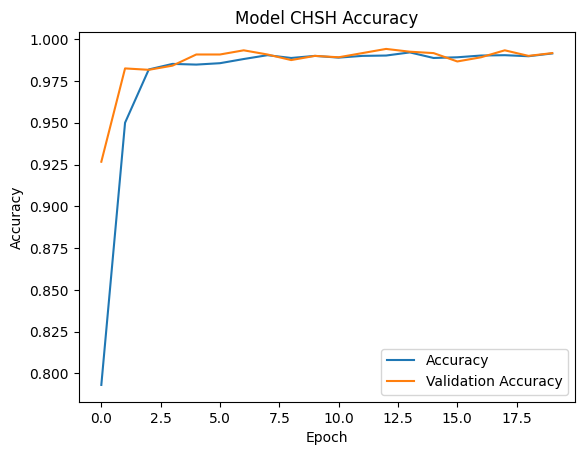

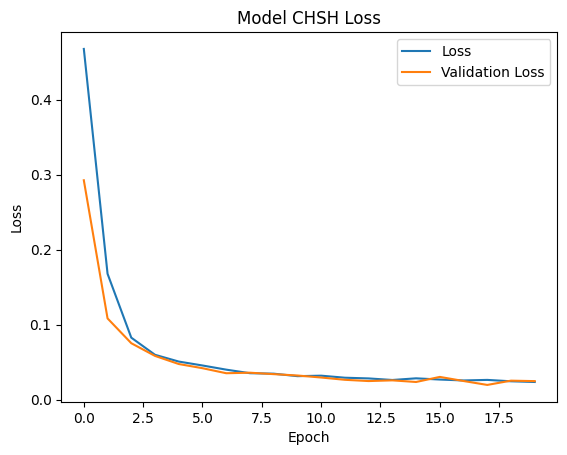

In [8]:
models = {}
if WITNESS_NAME is not None:
    parameter_witnesses = {WITNESS_NAME: witnesses[WITNESS_NAME]}
else: 
    parameter_witnesses = witnesses

for name, witness in parameter_witnesses.items():
    data_file_path = get_simulation_data_path(name)
    model, metrics = get_model(name, data_file_path)
    log_mlflow_model(model, name, metrics)
    models[name] = {"model": model, "witness": witness}
